In [78]:
# encoding: utf-8
%matplotlib inline
import spacy
import textacy
import textacy.keyterms
import scattertext as st
import pandas as pd
import empath
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from IPython.display import IFrame
from IPython.core.display import display, HTML

In [2]:
nlp = spacy.load('en_core_web_sm',disable_pipes=["tagger","ner"])
sent_analyser = SentimentIntensityAnalyzer()

In [516]:
twitter = pd.read_csv('./customer-support-on-twitter/twcs.csv')
twitter.shape

(2811774, 7)

In [4]:
companies = twitter.author_id.unique()
companies = [company for company in companies if company[0].isalpha()]
companies = sorted(companies)
for company in companies:
    print(company)

ATT
ATVIAssist
AWSSupport
AdobeCare
AirAsiaSupport
AirbnbHelp
AlaskaAir
AldiUK
AmazonHelp
AmericanAir
AppleSupport
ArbysCares
ArgosHelpers
AskAmex
AskCiti
AskDSC
AskLyft
AskPapaJohns
AskPayPal
AskPlayStation
AskRBC
AskRobinhood
AskSeagate
AskTarget
AskTigogh
AskVirginMoney
Ask_Spectrum
Ask_WellsFargo
AskeBay
AsurionCares
AzureSupport
BofA_Help
BoostCare
British_Airways
CarlsJr
CenturyLinkHelp
ChaseSupport
ChipotleTweets
CoxHelp
DellCares
Delta
DoorDash_Help
DropboxSupport
DunkinDonuts
GWRHelp
GloCare
GoDaddyHelp
GooglePlayMusic
GreggsOfficial
HPSupport
HiltonHelp
HotelTonightCX
IHGService
JackBox
JetBlue
KFC_UKI_Help
KeyBank_Help
Kimpton
LondonMidland
MOO
MTNC_Care
McDonalds
MicrosoftHelps
Morrisons
NeweggService
NikeSupport
NortonSupport
O2
OPPOCareIN
OfficeSupport
PandoraSupport
PearsonSupport
Postmates_Help
SCsupport
SW_Help
Safaricom_Care
SouthwestAir
SpotifyCares
TMobileHelp
TacoBellTeam
Tesco
TfL
TwitterSupport
UPSHelp
USCellularCares
Uber_Support
VMUcare
VerizonSupport
VirginAme

In [5]:
relevant_posts = twitter[twitter['author_id'].str.contains('', regex=False)]

In [27]:
twitter.text.str.len().mean()

113.88970735201336

In [19]:
tweet_ids = twitter[(twitter['author_id'] == 'AWSSupport')]['tweet_id']

client_requests = twitter[twitter['in_response_to_tweet_id'].isin(tweet_ids)]


(369, 7)


In [8]:
for idx, row in client_requests.iterrows():
    analysis = TextBlob(row['text'])
    if(analysis.sentiment.polarity < 0):
        print(analysis)
        print()

@AWSSupport I'm unable to post a message due to: https://t.co/RgTnkBQEPg :) I will try again later.

@AWSSupport No way around it? You're locking a customer out... I deny the usage due to unnecessary non-fair trade and burden on poor in China and Africa

@AWSSupport Does that number of subscription limit to topic add up every time we make call using same topic name or for a single request?

@AWSSupport Thank you, I didn't even knew about such limit on topic. That was well hidden in documentation to get noticed.

@AWSSupport it was on my side. my docker server was acting badly

@AWSSupport This didnt help. Site is still down &amp; I'm losing $. Need to talk 2 a human who will fix. Pls email __email__. Not a "noreply" email

@AWSSupport @160802 I thought this wud be a main feature. That's a #fail if it isn't. 1st things 1st. Save the trees.

@AWSSupport Any news on this subject?

@AWSSupport Typo in VPC Setup wizard. VPC With a Single Public Subnet says instances run in a private,isolate

In [9]:
corpus = textacy.corpus.Corpus('en_core_web_sm')

for idx, row in client_requests.iterrows():
    analysis = TextBlob(row['text'])
    if(analysis.sentiment.polarity < -0.0):
        corpus.add_text(row['text'])
        #print(analysis)
        #key_terms.append(textacy.keyterms.textrank(doc, normalize='lemma', n_keyterms=5))

In [ ]:
vectorizer = textacy.Vectorizer(
    tf_type='linear', 
    apply_idf=True, 
    idf_type='smooth', 
    norm='l2',min_df=2, max_df=0.95)

doc_term_matrix = vectorizer.fit_transform(
    (doc.to_terms_list(
        ngrams=1, named_entities=True, 
        as_strings=True) for doc in corpus)
    )

In [ ]:
model = textacy.TopicModel('nmf', n_topics=5)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)

In [ ]:
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=10):
    print('topic', topic_idx, ':', '   '.join(top_terms))

In [517]:
first_inbound = twitter[pd.isnull(twitter.in_response_to_tweet_id) & twitter.inbound]

QnR = pd.merge(first_inbound, twitter, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id')

# Filter to only outbound replies (from companies)
QnR = QnR[QnR.inbound_y ^ True]
print(f'Data shape: {QnR.shape}')

Data shape: (794299, 14)


In [518]:
#making sure the dataframe contains only the needed columns
QnR = QnR[["author_id_x","created_at_x","text_x","author_id_y","created_at_y","text_y"]]

In [519]:
azureQnR = QnR[QnR["author_id_y"]=="AzureSupport"]
awsQnR = QnR[QnR["author_id_y"]=="AWSSupport"]

azureQnR['created_at_y'] = pd.to_datetime(azureQnR.created_at_y)
awsQnR['created_at_y'] = pd.to_datetime(awsQnR.created_at_y)

azureQnR['delta'] =pd.to_datetime(azureQnR.created_at_y)-pd.to_datetime(azureQnR.created_at_x) 
awsQnR['delta'] = pd.to_datetime(awsQnR.created_at_y)-pd.to_datetime(awsQnR.created_at_x) 

azureQnR = azureQnR[azureQnR['created_at_y'] > pd.Timestamp(2017,9,1)]
awsQnR = awsQnR[awsQnR['created_at_y'] > pd.Timestamp(2017,9,1)]

(758, 7)
AWS min: 12.133333333333333
AWS mean: 1534.7575857519666
AWS median: 148.91666666666666
AWS 0.75 quant: 262.22083333333336
AWS 0.9 quant: 522.625
(3544, 7)
Azure min: 0.03333333333333333
Azure mean: 429.6829053799833
Azure median: 2.8666666666666667
Azure 0.75 quant: 5.15
Azure 0.9 quant: 26.249999999983334


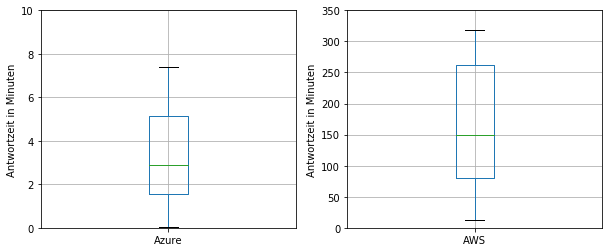

created_at_y
2017-09-30   1 days 17:20:50.972972
2017-10-31   0 days 21:06:26.901197
2017-11-30   1 days 06:31:39.255014
2017-12-31   0 days 04:05:05.894736
Freq: M, Name: delta, dtype: timedelta64[ns]

In [503]:
azureDelta = azureQnR['delta'] 
awsDelta = awsQnR['delta']

awsQnR.index = awsQnR['created_at_y']
azureQnR.index = azureQnR['created_at_y']

td_h = np.timedelta64(1, 'm')

aws_mean = awsDelta.mean()/ td_h
aws_min = awsDelta.min()/ td_h
aws_max = awsDelta.max()/ td_h
aws_median = awsDelta.median()/ td_h
aws_075q = awsDelta.quantile(0.75)/ td_h
aws_025q = awsDelta.quantile(0.25)/ td_h
aws_01q = awsDelta.quantile(0.1)/ td_h
aws_08q = awsDelta.quantile(0.8)/ td_h

azure_mean = azureDelta.mean()/ td_h
azure_min = azureDelta.min()/ td_h
azure_max = azureDelta.max()/ td_h
azure_median = azureDelta.median()/ td_h
azure_075q = azureDelta.quantile(0.75)/ td_h
azure_025q = azureDelta.quantile(0.25)/ td_h
azure_01q = azureDelta.quantile(0.1)/ td_h
azure_08q = azureDelta.quantile(0.8)/ td_h

print(awsQnR.shape)
print("AWS min:",aws_min)
print("AWS mean:",aws_mean)
print("AWS median:",aws_median)
print("AWS 0.75 quant:",aws_075q)
print("AWS 0.9 quant:",aws_09q)
      
print(azureQnR.shape)
print("Azure min:", azure_min)
print("Azure mean:",azure_mean)
print("Azure median:",azure_median)
print("Azure 0.75 quant:",azure_075q)
print("Azure 0.9 quant:",azure_09q)

boxdf_both = pd.DataFrame([[aws_025q,azure_025q],[aws_median,azure_median],[aws_075q,azure_075q]], columns=['AWS', 'Azure'])
boxdf_aws = pd.DataFrame([[aws_min],[aws_025q],[aws_median],[aws_075q], [aws_08q]], columns=['AWS'])
boxdf_azure = pd.DataFrame([[azure_min],[azure_025q],[azure_median],[azure_075q],[azure_08q]], columns=['Azure'])

#boxplot_aws = boxdf_aws.boxplot(column=['AWS'], showfliers=False)
#boxplot_aws_fig = boxplot_aws.get_figure()
#boxplot_aws_fig.savefig("AWS_barplot.png")

#boxplot_azure = boxdf_azure.boxplot(column=['Azure'], showfliers=False)
#boxplot_azure_fig = boxplot_azure.get_figure()
#boxplot_azure_fig.savefig("Azure_barplot.png")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4)) 
plt.subplots_adjust(right=1.1)

boxdf_azure.boxplot(column=['Azure'], showfliers=True, ax=axes[0], showmeans=False, meanline=False)
boxdf_aws.boxplot(column=['AWS'], showfliers=True, ax=axes[1], showmeans=False, meanline=False)

axes[0].set_ylim([0,10])
axes[0].set_ylabel('Antwortzeit in Minuten')
axes[1].set_ylim([0,350])
axes[1].set_ylabel('Antwortzeit in Minuten')

plt.show()

azureQnR.groupby(pd.Grouper(freq='M'))['delta'].mean(numeric_only=False)
awsQnR.groupby(pd.Grouper(freq='M'))['delta'].mean(numeric_only=False)


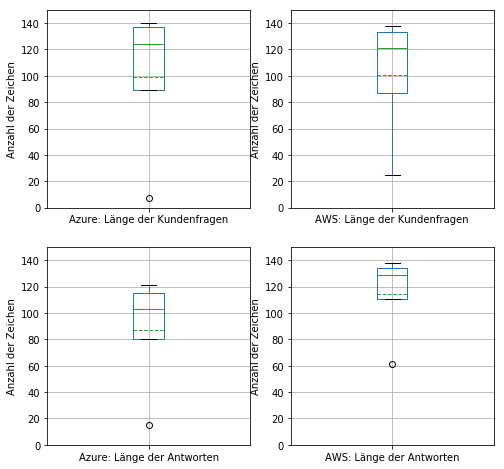

124.0
103.0
121.0
128.5


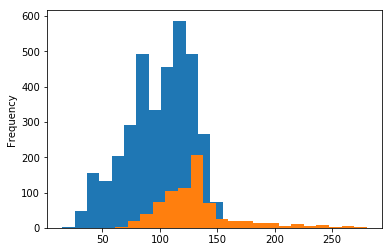

In [411]:
az_x = azureQnR.text_x.str.len()
az_y = azureQnR.text_y.str.len()
aw_x = awsQnR.text_x.str.len()
aw_y = awsQnR.text_y.str.len()

az_x_box = [az_x.min(), az_x.quantile(0.25), az_x.median(), az_x.quantile(0.65), az_x.quantile(0.75)]
az_y_box = [az_y.min(), az_y.quantile(0.25), az_y.median(), az_y.quantile(0.65), az_y.quantile(0.75)]
aw_x_box = [aw_x.min(), aw_x.quantile(0.25), aw_x.median(), aw_x.quantile(0.65), aw_x.quantile(0.75)]
aw_y_box = [aw_y.min(), aw_y.quantile(0.25), aw_y.median(), aw_y.quantile(0.65), aw_y.quantile(0.75)]

boxdf_aws_x = pd.DataFrame(aw_x_box, columns=['AWS: Länge der Kundenfragen'])
boxdf_azure_x = pd.DataFrame(az_x_box, columns=['Azure: Länge der Kundenfragen'])

boxdf_aws_y = pd.DataFrame(aw_y_box, columns=['AWS: Länge der Antworten'])
boxdf_azure_y = pd.DataFrame(az_y_box, columns=['Azure: Länge der Antworten'])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8)) # create 2x2 array of subplots

boxdf_azure_x.boxplot(column=['Azure: Länge der Kundenfragen'], ax=axes[0,0], showmeans=True, meanline=True) # add boxplot to 1st subplot
boxdf_azure_y.boxplot(column=['Azure: Länge der Antworten'], ax=axes[1,0], showmeans=True, meanline=True)# add boxplot to 2nd subplot
boxdf_aws_x.boxplot(column=['AWS: Länge der Kundenfragen'], ax=axes[0,1], showmeans=True, meanline=True) # add boxplot to 1st subplot
boxdf_aws_y.boxplot(column=['AWS: Länge der Antworten'], ax=axes[1,1], showmeans=True, meanline=True)# add boxplot to 2nd subplot
# etc.

axes[0,0].set_ylim([0,150])
axes[0,0].set_ylabel('Anzahl der Zeichen')
axes[0,1].set_ylim([0,150])
axes[0,1].set_ylabel('Anzahl der Zeichen')
axes[1,0].set_ylim([0,150])
axes[1,0].set_ylabel('Anzahl der Zeichen')
axes[1,1].set_ylim([0,150])
axes[1,1].set_ylabel('Anzahl der Zeichen')

plt.show()

print(az_x_box[2])
print(az_y_box[2])
print(aw_x_box[2])
print(aw_y_box[2])
az_y.plot.hist(bins=20)
aw_y.plot.hist(bins=20)

In [385]:
cloudProviderQnR = QnR[(QnR["author_id_y"]=="AzureSupport")|(QnR["author_id_y"]=="AWSSupport")] 
print("Q:",cloudProviderQnR.text_x.str.len().mean())
print("A:",cloudProviderQnR.text_y.str.len().mean())
cloudProviderQnR.describe()

Q: 120.63436123348018
A: 105.35404590772085


,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y
count,4313,4313,4313,4313,4313,4313
unique,3242,3792,3537,2,4303,4307
top,171988,Sat Oct 21 12:30:16 +0000 2017,@azuresupport #azTechHelp,AzureSupport,Thu Nov 16 21:48:38 +0000 2017,"@337024 Hello, do you still have access to the..."
freq,9,4,187,3549,2,2


In [248]:
cloudProviderQnR_head = cloudProviderQnR.sample(5)
cloudProviderQnR_head = cloudProviderQnR_head[["author_id_x","created_at_x","text_x","author_id_y","created_at_y","text_y"]]
cloudProviderQnR_head = cloudProviderQnR_head.rename(index=str, columns={"author_id_x": "Fragesteller","created_at_x":"Zeitstempel Frage","text_x": "Fragetext",
 "author_id_y": "Antwortgeber","created_at_y":"Zeitstempel Antwort","text_y": "Antworttext"})
cloudProviderQnR_head['Zeitstempel Frage']= pd.to_datetime(cloudProviderQnR_head['Zeitstempel Frage']).dt.strftime('%d.%m.%Y %H:%M:%S')
cloudProviderQnR_head['Zeitstempel Antwort']= pd.to_datetime(cloudProviderQnR_head['Zeitstempel Antwort']).dt.strftime('%d.%m.%Y %H:%M:%S')
cloudProviderQnR_head.head()


,Fragesteller,Zeitstempel Frage,Fragetext,Antwortgeber,Zeitstempel Antwort,Antworttext
771294,23873,17.11.2017 22:00:12,@AzureSupport \n\nSee - https://t.co/HMtuOPiIi...,AzureSupport,17.11.2017 22:10:13,@23873 Thank you. We have alerted the team to ...
363020,428432,27.10.2017 08:48:51,@azuresupport #azTechHelp Why I can't see unde...,AzureSupport,27.10.2017 08:50:51,@428432 Would these be VMs that were recently ...
376951,439405,19.09.2017 09:42:25,"@azuresupport #azTechHelp Hello,I would like a...",AzureSupport,22.09.2017 04:04:46,@439405 Was the documentation helpful that we ...
870124,819889,30.11.2017 01:34:56,@61186 @AzureSupport I'm trying to reach Azure...,AzureSupport,30.11.2017 01:36:44,@819889 Hi there. We recommend filing a free b...
191215,289367,10.10.2017 19:58:44,@azuresupport #azTechHelp COMO FAÇO UMA COPIA ...,AzureSupport,13.10.2017 04:44:37,"@289367 Hey, just checking to see if you were ..."


In [520]:
twitter_specific_stopwords = ['para','como','it’s','e\.g\.','i\.e\.','gt;','[a-z]+’[a-z]+', '[0-9]+', '[\-/#_$]','[ ][A-Za-z0-9]{1,3}[ ]','[a-z]+\'[a-zA-Z]+', 'amp\;', '\@[0-9a-zA-Z]+' ,'\+', '&', '\'[a-z]+','\^[A-Za-z]+','(http|https|ftp)\://([a-zA-Z0-9\-\.]+\.+[a-zA-Z]{2,3})(:[a-zA-Z0-9]*)?/?([a-zA-Z0-9\-\._\?\,\'/\\\+&amp;%\$#\=~]*)[^\.\,\)\(\s]?']

In [521]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
stopword_list = []
with open("stopwords-1.txt", "r") as f:
    stopword_list = stopword_list + f.read().split(',')
    
with open("stopwords-2.txt", "r") as f:
    stopword_list = stopword_list + f.read().split(',')
    
with open("stopwords-3.txt", "r") as f:
    stopword_list = stopword_list + f.read().split(',')

In [522]:
stop = stopwords.words('english') + list(spacy.lang.en.stop_words.STOP_WORDS) + stopword_list

In [523]:
cloudProviderQnR["text_y"] = cloudProviderQnR["text_y"].str.lower()  
#big_regex = re.compile(' | '.join(stop))
other_regex = re.compile('|'.join(twitter_specific_stopwords))
cloudProviderQnR["text_y"] = cloudProviderQnR["text_y"].apply(lambda x: other_regex.sub(" ",x))
#cloudProviderQnR["text_y"] = cloudProviderQnR["text_y"].apply(lambda x: big_regex.sub(" ",x))
#cloudProviderQnR["text_y"].head()

In [524]:
cloudProviderQnR["text_x"] = cloudProviderQnR["text_x"].str.lower()  
#big_regex = re.compile(' | '.join(stop))
other_regex = re.compile('|'.join(twitter_specific_stopwords))
cloudProviderQnR["text_x"] = cloudProviderQnR["text_x"].apply(lambda x: other_regex.sub(" ",x))
#cloudProviderQnR["text_x"] = cloudProviderQnR["text_x"].apply(lambda x: big_regex.sub(" ",x))
#cloudProviderQnR["text_x"].head()

In [525]:
print("Q:",cloudProviderQnR.text_x.str.len().mean())
print("A:",cloudProviderQnR.text_y.str.len().mean())

Q: 87.79758868536982
A: 69.83654069093438


In [526]:
cloudProviderQnR['parsed_x'] = cloudProviderQnR.text_x.apply(nlp)
corpus_x = st.CorpusFromParsedDocuments(cloudProviderQnR,
                             category_col='author_id_y',
                             parsed_col='parsed_x').build().get_stoplisted_unigram_corpus_and_custom(stop)

In [527]:
html = st.produce_scattertext_explorer(corpus_x,
          category='AzureSupport',
          category_name='Azure Support',
          not_category_name='AWSSupport',
          width_in_pixels=850,
          minimum_term_frequency=25,
          use_full_doc=True, 
          term_significance = st.LogOddsRatioUninformativeDirichletPrior(),
    )

In [528]:
# uncomment this cell to load the interactive scattertext visualisation
filename = "azure-vs-aws_clients.html"
open(filename, 'wb').write(html.encode('utf-8'))
IFrame(src=filename, width = 850, height=700)

In [529]:
cloudProviderQnR['parsed_y'] = cloudProviderQnR.text_y.apply(nlp)
corpus_y = st.CorpusFromParsedDocuments(cloudProviderQnR,
                             category_col='author_id_y',
                             parsed_col='parsed_y').build().get_stoplisted_unigram_corpus_and_custom(stop)

In [530]:
html = st.produce_scattertext_explorer(corpus_y,
          category='AzureSupport',
          category_name='Azure Support',
          not_category_name='AWSSupport',
          width_in_pixels=800,
          minimum_term_frequency=7,
          term_significance = st.LogOddsRatioUninformativeDirichletPrior(),
          x_label= 'AWS Support Worthäufigkeit',
          y_label= 'Azure Support Worthäufigkeit',                             
          )

In [531]:
# uncomment this cell to load the interactive scattertext visualisation
filename = "azure-vs-aws.html"
open(filename, 'wb').write(html.encode('utf-8'))
IFrame(src=filename, width = 800, height=700)

In [292]:
feat_builder = st.FeatsFromOnlyEmpath()
empath_corpus = st.CorpusFromParsedDocuments(cloudProviderQnR,
                                              category_col='author_id_y',
                                              feats_from_spacy_doc=feat_builder,
                                              parsed_col='parsed_y').build()

In [293]:
html = st.produce_scattertext_explorer(empath_corpus,
                                        category='AzureSupport',
                                        category_name='Azure Support',
                                        not_category_name='AWSSupport',
                                        width_in_pixels=700,
                                        metadata=cloudProviderQnR['author_id_y'],
                                        use_non_text_features=True,
                                        use_full_doc=True,
                                        topic_model_term_lists=feat_builder.get_top_model_term_lists())

In [294]:
# uncomment this cell to load the interactive scattertext visualisation
filename = "emp-azure-vs-aws.html"
open(filename, 'wb').write(html.encode('utf-8'))
IFrame(src=filename, width = 800, height=700)

In [295]:
corpus = (st.CorpusFromParsedDocuments(cloudProviderQnR,
                             category_col='author_id_y',
                             parsed_col='parsed_y').build().get_stoplisted_unigram_corpus())

In [300]:
target_term = 'sorry'
html = st.word_similarity_explorer(corpus,
                                   category='AzureSupport',
                                   category_name='Azure Support',
                                   not_category_name='AWSSupport',
                                   target_term=target_term,
                                   minimum_term_frequency=5,
                                   width_in_pixels=800)

In [301]:
# uncomment this cell to load the interactive scattertext visualisation
filename = "wordsim-azure-vs-aws.html"
open(filename, 'wb').write(html.encode('utf-8'))
IFrame(src=filename, width = 800, height=700)

In [310]:
corpus = (st.CorpusFromPandas(cloudProviderQnR,
                              category_col='author_id_y',
                              text_col='parsed_y',
                              nlp=st.whitespace_nlp_with_sentences)
          .build()
          .get_unigram_corpus()
          .compact(st.ClassPercentageCompactor(term_count=2,
                                               term_ranker=st.OncePerDocFrequencyRanker)))

TypeError: ('expected string or bytes-like object', 'occurred at index 0')

In [315]:
corpus = (st.CorpusFromParsedDocuments(cloudProviderQnR,
                             category_col='author_id_y',
                             parsed_col='parsed_x').build().get_stoplisted_unigram_corpus()).compact(st.ClassPercentageCompactor(term_count=2,
                                               term_ranker=st.OncePerDocFrequencyRanker))

html = st.produce_characteristic_explorer(corpus,
                                          category='AzureSupport',
                                          category_name='Azure Support',
                                          not_category_name='AWSSupport',
                                          metadata=corpus.get_df()['parsed_y']
)

In [316]:
# uncomment this cell to load the interactive scattertext visualisation
filename = "characteristics.html"
open(filename, 'wb').write(html.encode('utf-8'))
IFrame(src=filename, width = 800, height=700)